In [1]:
from cosmic.sample.initialbinarytable import InitialBinaryTable
from cosmic.sample.sampler import multidim
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap


import numpy as np

import astropy.constants as const
import astropy.units as u

from tqdm import tqdm

import pandas as pd

plt.rcParams.update({
    'figure.figsize':(7,7),
    'xtick.major.width':1,
    'ytick.major.width':1,
    'xtick.minor.width':1,
    'ytick.minor.width':1,
    'xtick.major.size':8,
    'ytick.major.size': 6,
    'xtick.minor.size':3,
    'ytick.minor.size':3,
    'font.family':'STIXGeneral',
    'font.size':16,
#    'xtick.top':True,
#    'ytick.right':True,
    'xtick.direction':'in',
    'ytick.direction':'in',
    'mathtext.fontset': 'cm',
    'mathtext.rm': 'serif'})   

def make_plot_nice(ax):
    """
    """    
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')  # or 'bottom'                                                    
    ax.tick_params(direction='in',axis='both',which='minor',length=3,width=1,labelsize=14)
    ax.tick_params(direction='in',axis='both',which='major',length=6,width=1,labelsize=14)
    ax.minorticks_on()  
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)

    return

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """Return a truncated colormap."""
    new_cmap = LinearSegmentedColormap.from_list(
        f"{cmap.name}_trunc", cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap
trunc_magma = truncate_colormap(plt.cm.magma, 0.0, 0.9)

In [2]:
# helper functions for data generation
def draw_inclinations(n):
    """
    draw n isotropic inclinations
    """
    theta = np.arccos(1-2*np.random.rand(n))
    return theta

def calc_amplitude(M1, M2, P, e, inclination):
    """
    provide everything as astropy quantities
    """
    Mtot = M1 + M2
    
    t1 = (M2 * np.sin(inclination)) / np.sqrt(1-e**2)
    t2 = ((2*np.pi * const.G)/(P * Mtot**2))**(1/3)

    K = t1 * t2
    return K

## The initial binary sampling using `COSMIC`

Note, the code below ignores a bug in `COSMIC`'s multidimensional sampler leading to an incorrect IMF for the primaries. We'll ignore it for this project but it should be fixed eventually, since our SBI model should be highly sensitive to the prior it trains on. See [here](https://github.com/COSMIC-PopSynth/COSMIC/issues/662) for more details.

Another note -- no need to re-run this code (e.g. if you don't have COSMIC set up), the resulting initial binary table is saved at `data/cosmic_ibt.csv`.

In [3]:
# ### I'll generate 1e6 systems, but only sample 1e4 of them (otherwise training takes SO LONG)
# InitialBinaries, mass_singles, mass_binaries, n_singles, n_binaries = InitialBinaryTable.sampler('multidim', primary_model = 'kroupa01', 
#             final_kstar1=[6], final_kstar2=[6], rand_seed=2, nproc=1, SF_start=13700.0, SF_duration=0.0, met=0.0002, size=100000, ### metallicity of a GC
#                                     )

In [4]:
# tab = InitialBinaries
# tab.to_csv('data/cosmic_ibt.csv')
tab = pd.read_csv('data/cosmic_ibt.csv')

## Sample the InitialBinaryTable, generate labels

We'll also generate and plot the binary properties.

Note, because my train/test data is too large to upload to github, you should rerun the rest of this notebook to generate your own.

In [5]:
N = int(1e6) # sample 1e6 binaries for training 
out = tab.sample(N, replace=True, random_state=33)

In [6]:
### extract periods, masses, eccentricities
logPs = np.array(np.log10(out['porb']))
M1s = np.array(out['mass_1'])
M2s = np.array(out['mass_2'])
eccs = np.array(out['ecc'])

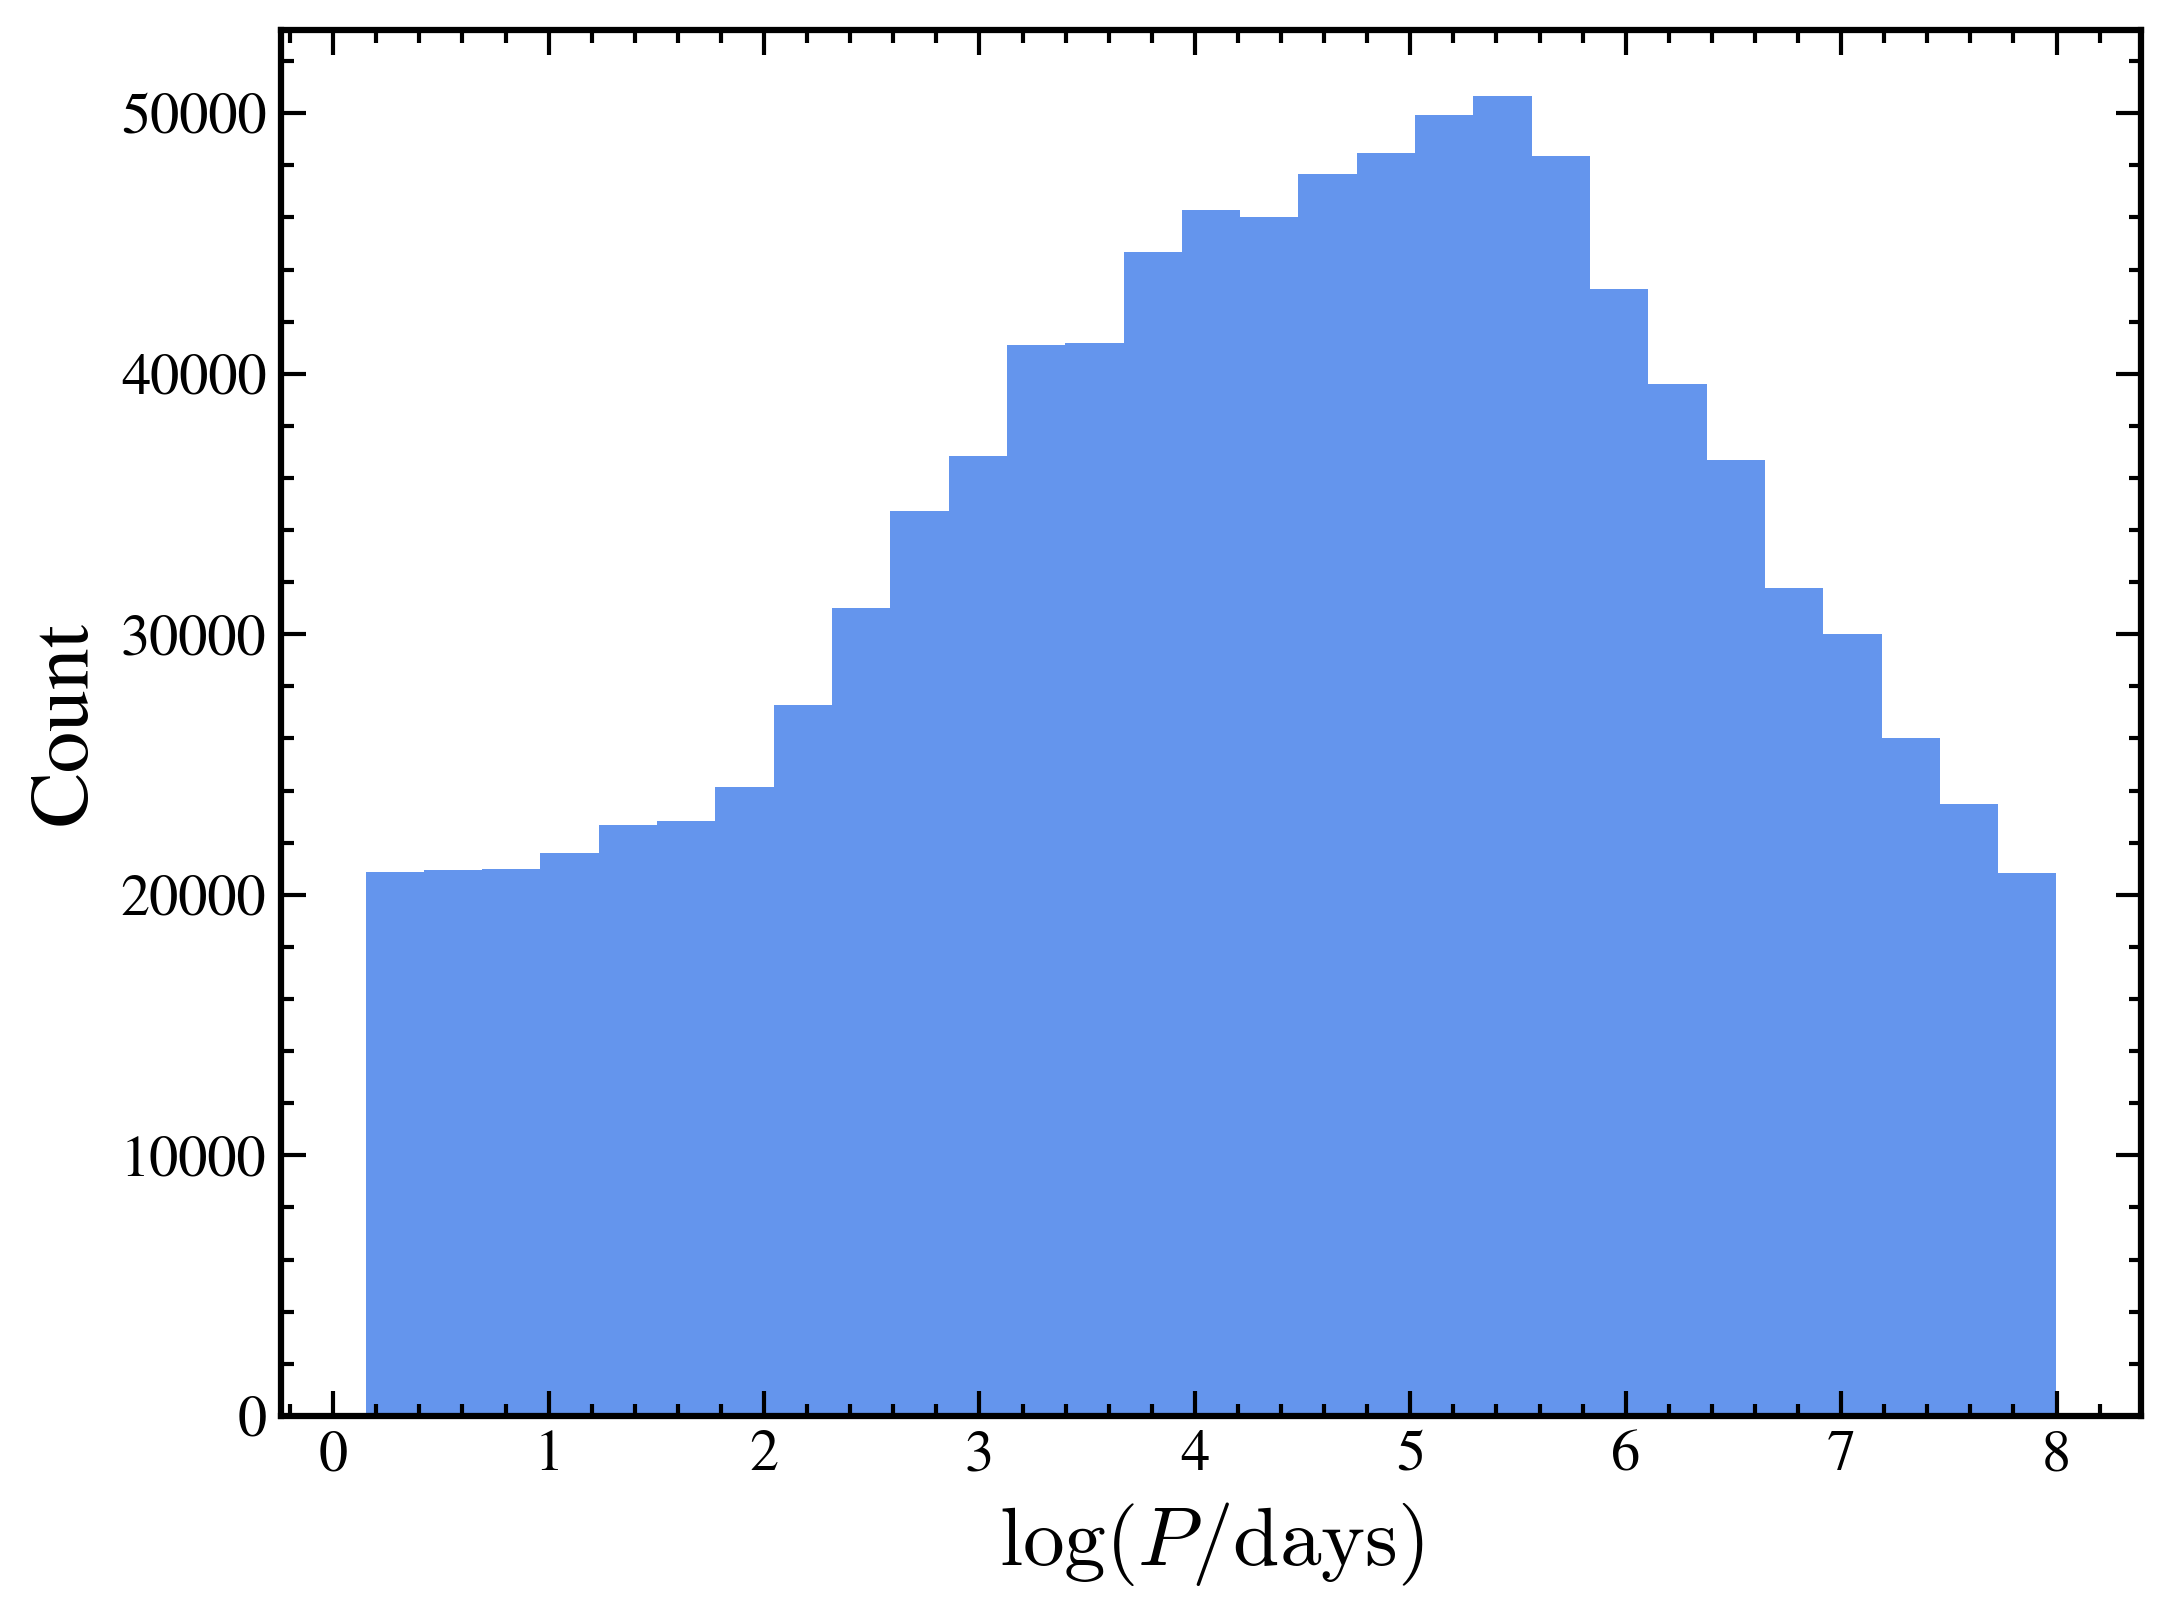

In [7]:
# plot orbital period distribution:
fig, ax = plt.subplots(figsize=[8,6], dpi=300)

bins = np.linspace(np.min(logPs), np.max(logPs),30)
ax.hist(logPs, bins=bins, color='cornflowerblue', histtype='bar', alpha=1)

ax.set_xlabel(r"$\log(P/\rm{days})$", fontsize=20)
ax.set_ylabel("Count", fontsize=20)

make_plot_nice(ax)

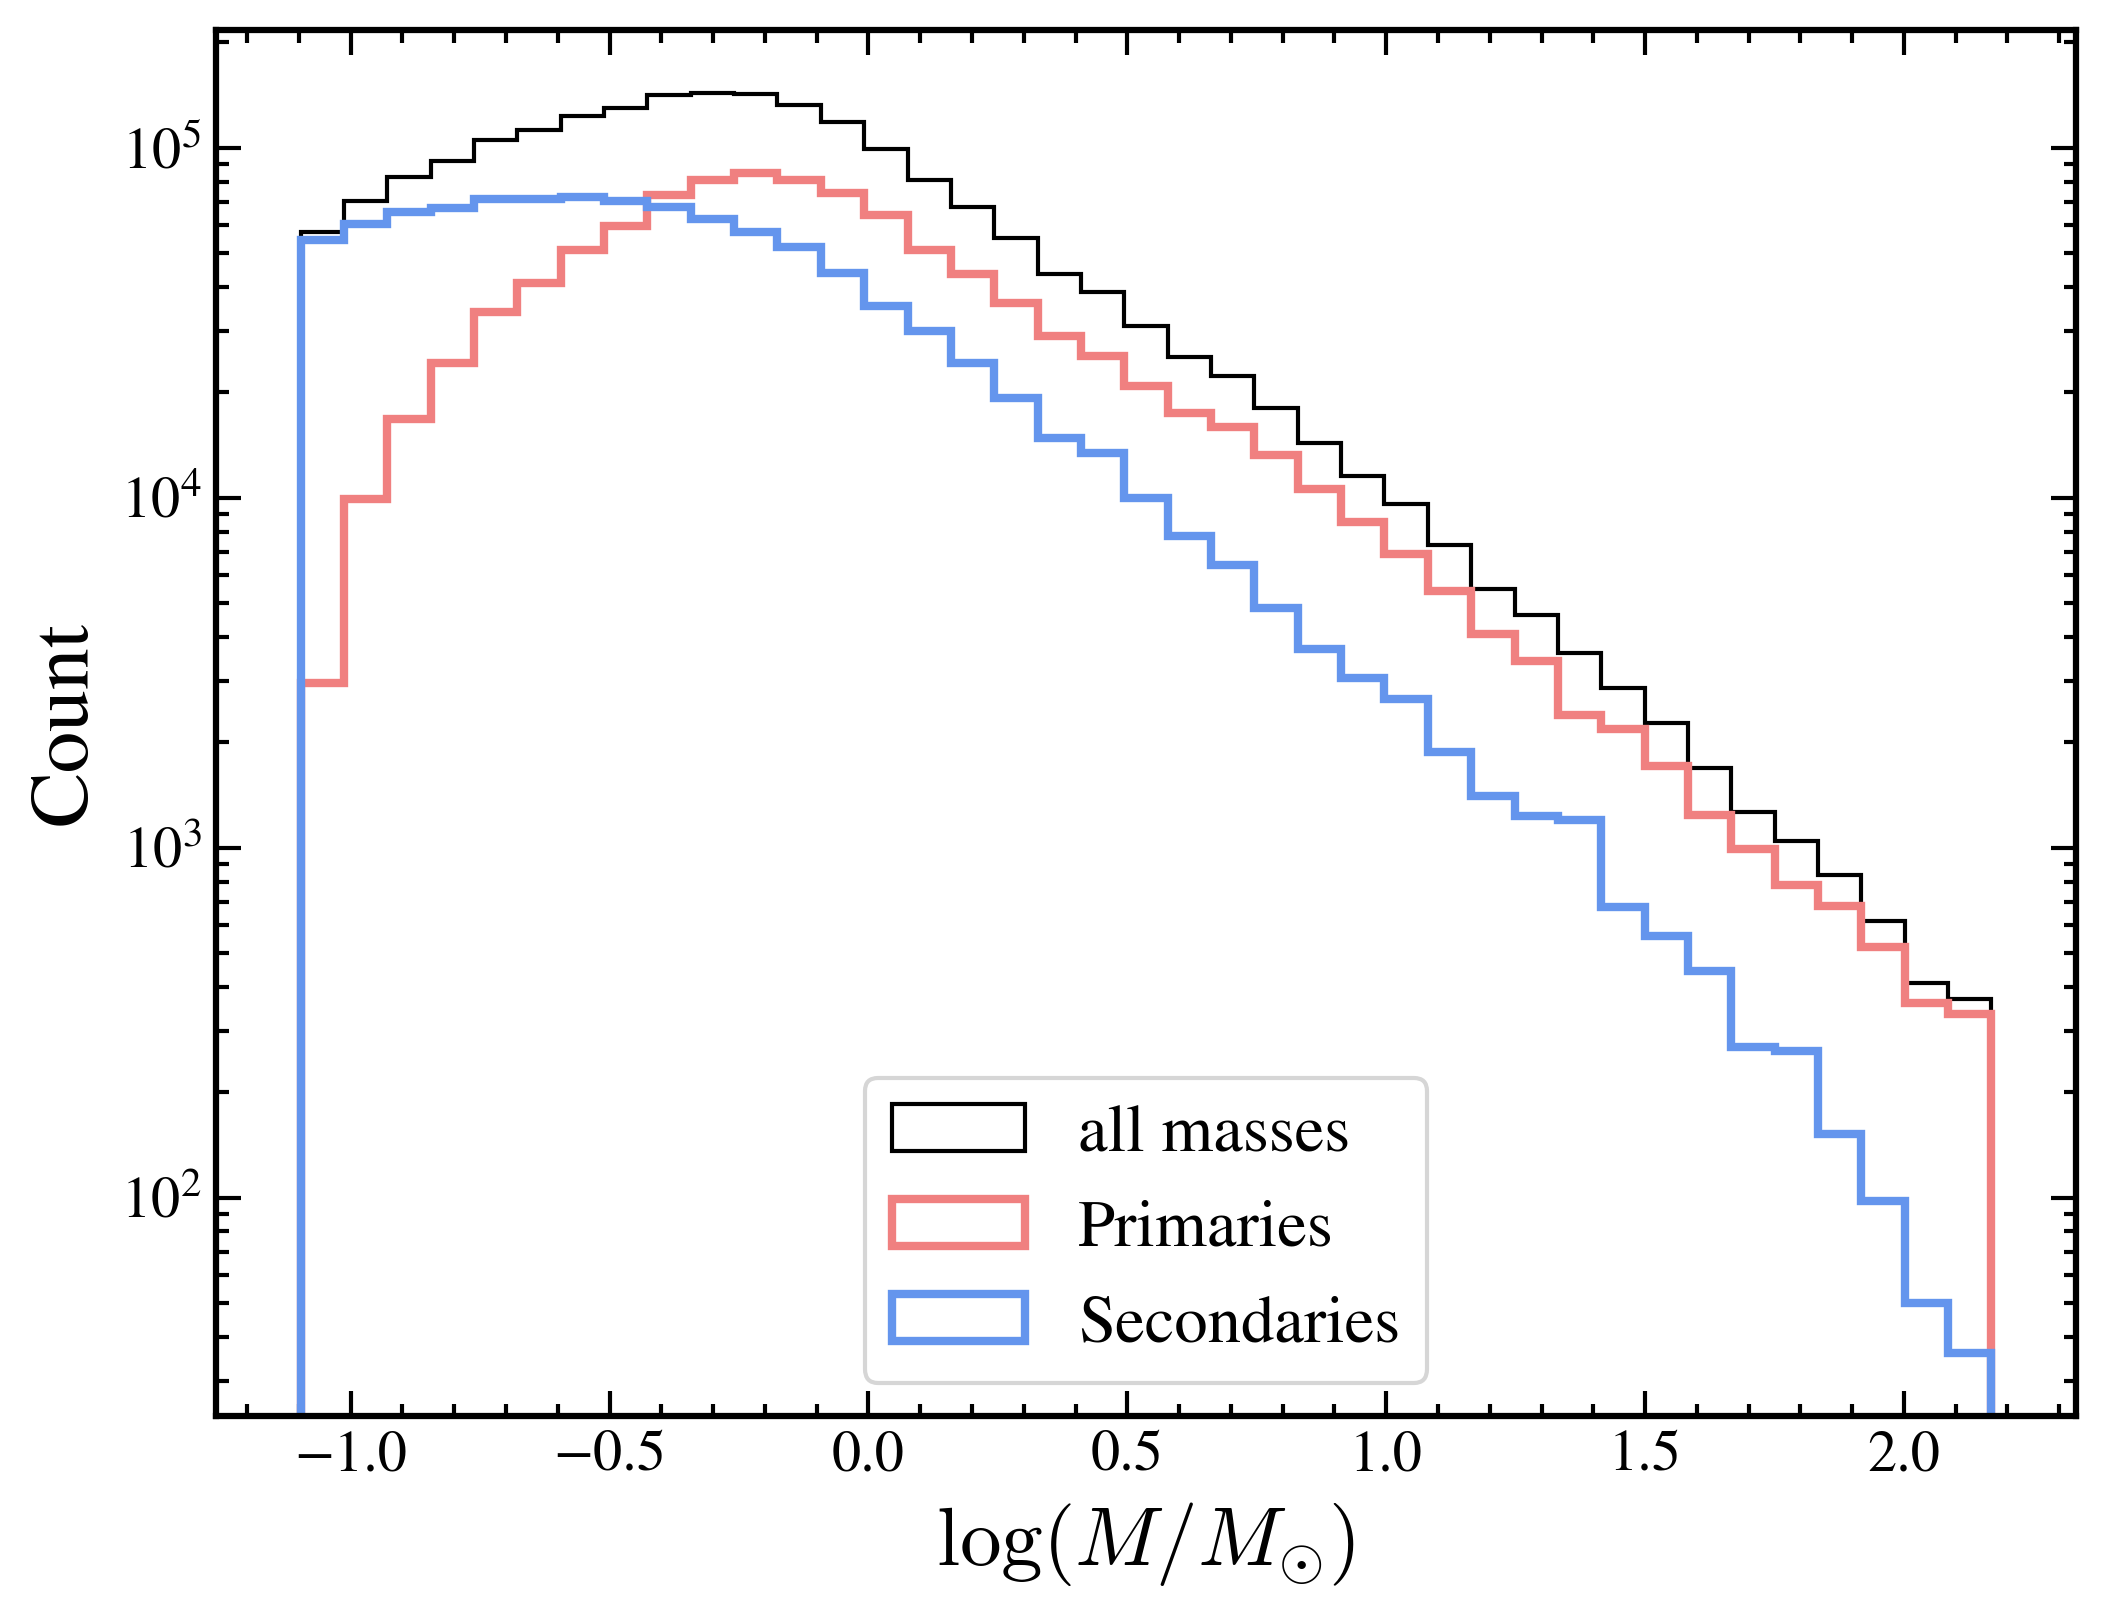

In [8]:
# plot mass distribution:
all_masses = np.concatenate([M1s, M2s])

fig, ax = plt.subplots(figsize=[8,6], dpi=300)

bins = np.linspace(np.min(np.log10(all_masses)), np.max(np.log10(all_masses)),40)

ax.hist(np.log10(all_masses), bins=bins, color='k', histtype='step', label='all masses')
ax.hist(np.log10(M1s), bins=bins, histtype='step', color='lightcoral',linewidth=2, label='Primaries')
ax.hist(np.log10(M2s), bins=bins, histtype='step', color='cornflowerblue',linewidth=2, label='Secondaries')

ax.set_yscale('log')
# ax.axvline(np.log10(0.08))
# ax.axvline(np.log10(0.5), c='r')

ax.set_xlabel(r'$\log(M/M_{\odot})$', fontsize=20)
ax.set_ylabel('Count', fontsize=20)
ax.legend(loc='lower center')
make_plot_nice(ax)

plt.savefig("plots/masses.pdf", dpi=300, bbox_inches="tight")
plt.savefig("plots/masses.png", dpi=300, bbox_inches="tight")

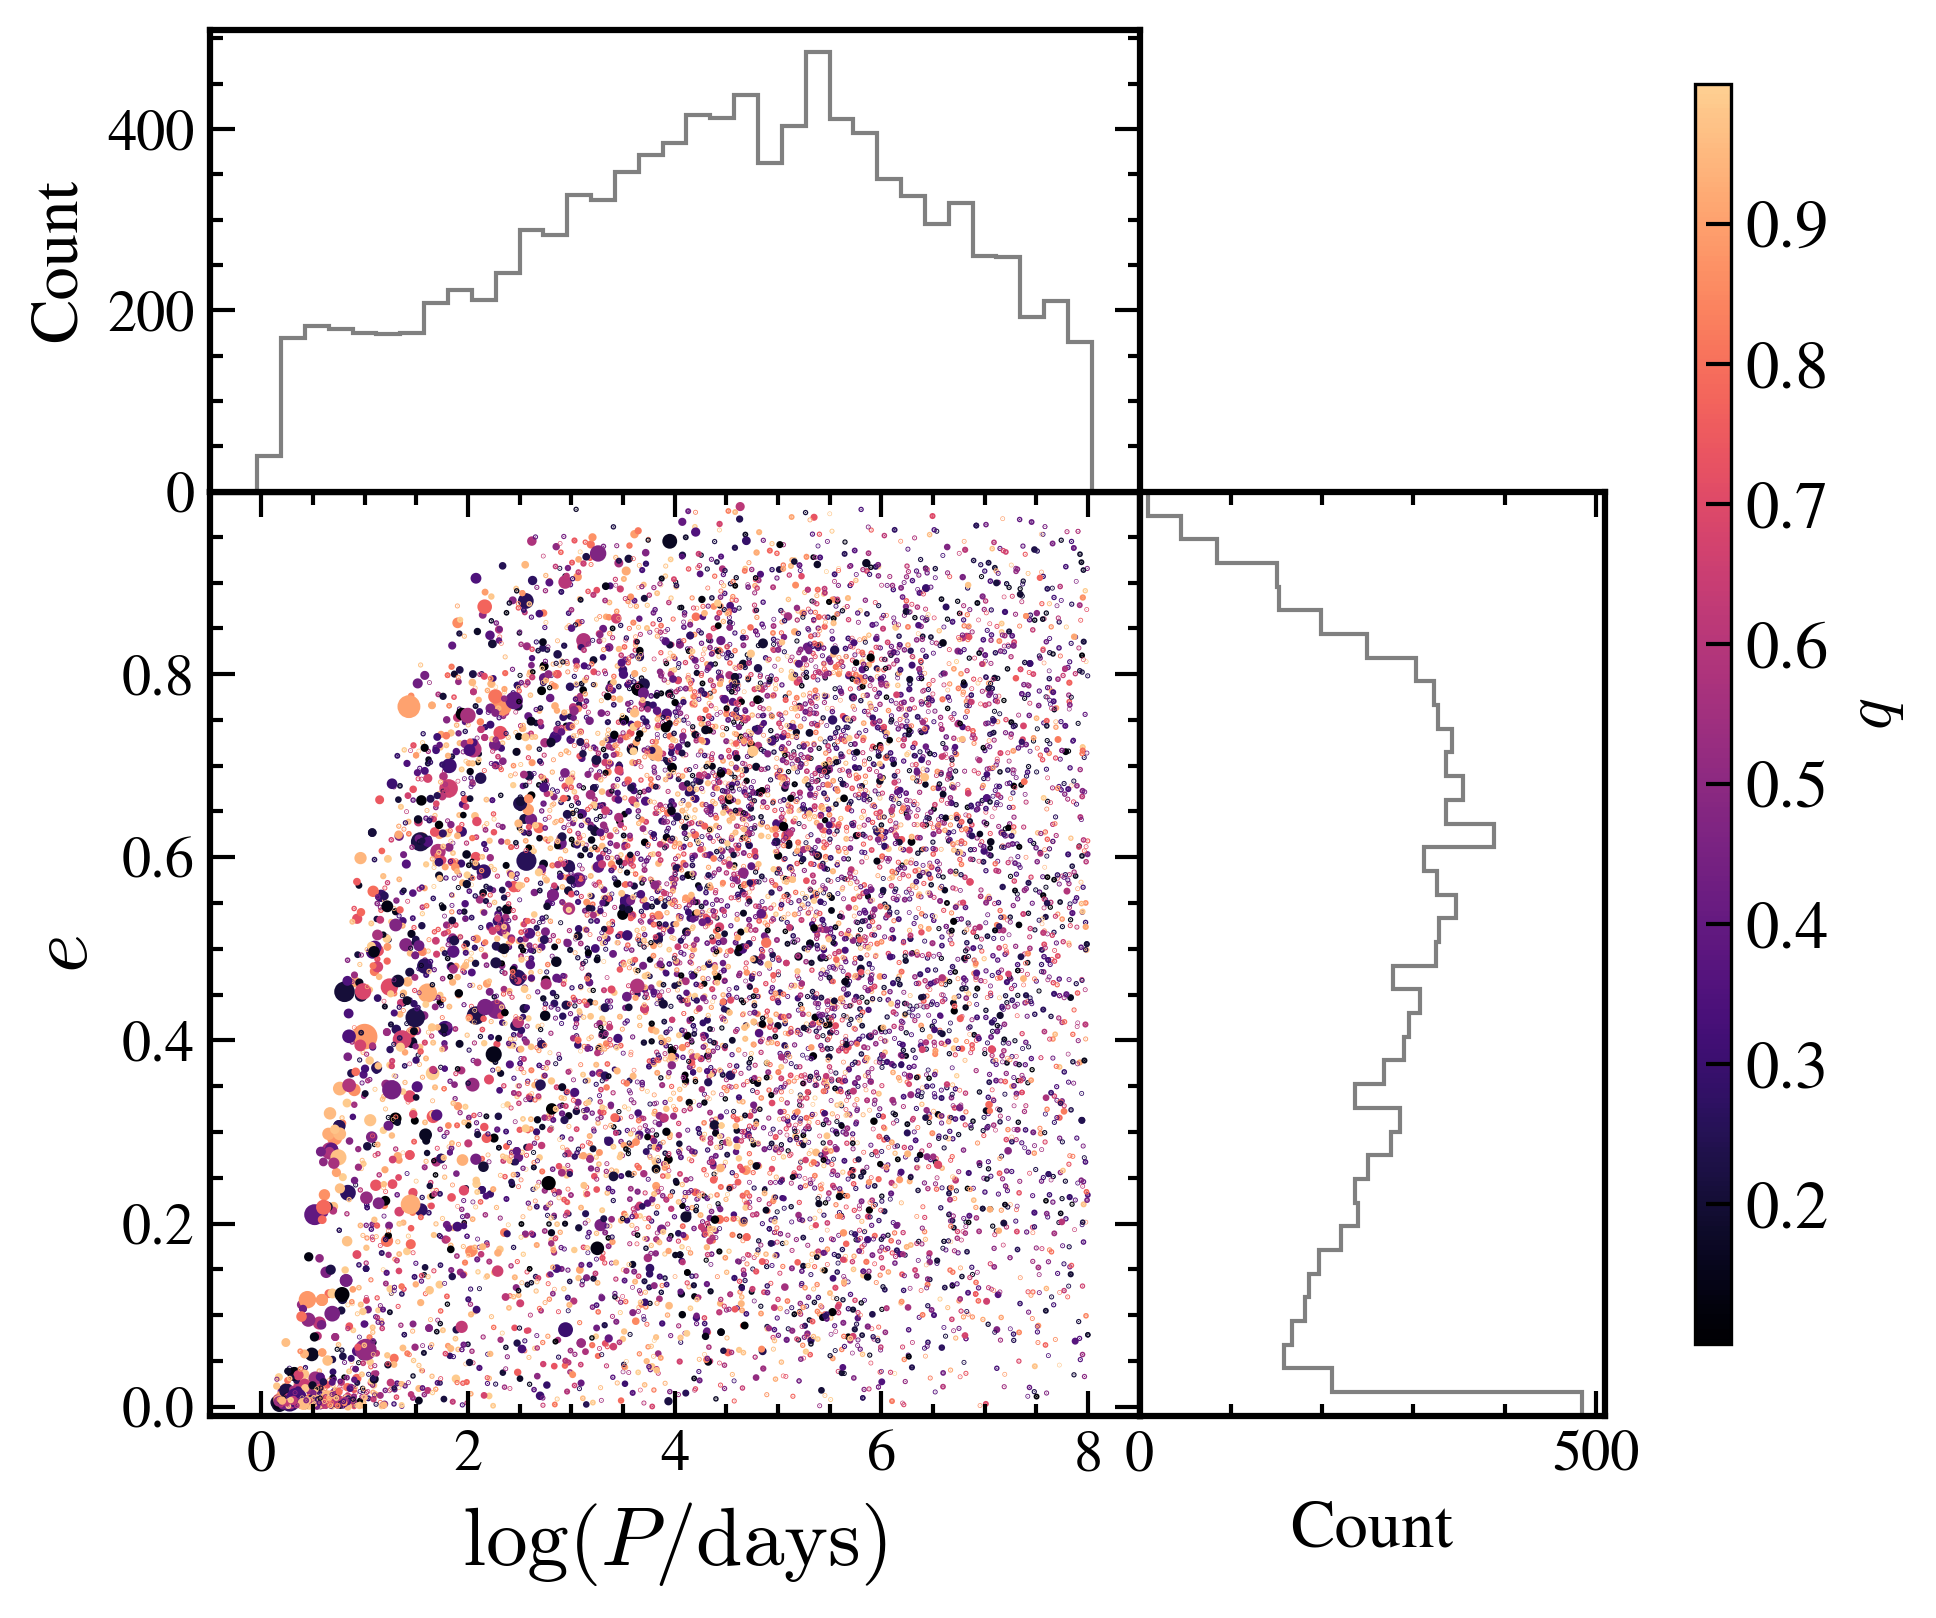

In [9]:
# plot orbital period and eccentricity distributions



fig = plt.figure(figsize=(6,6),dpi=300) 
gs = fig.add_gridspec(2, 2, width_ratios=[2, 1], height_ratios=[1, 2]) 

#### plot just a random subset

ind = np.random.randint(low=0, high=len(logPs), size=10000)


axexy = fig.add_subplot(gs[1,0])
axehx = fig.add_subplot(gs[0,0],sharex=axexy)
axehy = fig.add_subplot(gs[1,1],sharey=axexy)
axehx.get_xaxis().set_visible(False)
axehy.get_yaxis().set_visible(False)
plt.subplots_adjust(hspace=0.0,wspace=0.0)

xlim=[-0.5,8.5]
ylim=[-0.01,0.999]
axexy.set_xlim(*xlim)
axexy.set_ylim(*ylim)
# axehx.set_xscale('log')
axexy.set_xlabel(r'$\log(P/\rm{days})$',fontsize=20)
axexy.set_ylabel(r'$e$',fontsize=20)

nbinx=40
nbiny=40
log_xbins=np.linspace(xlim[0],xlim[1], nbinx)
ybins=np.linspace(ylim[0], ylim[1], nbiny)

x = logPs[ind]
y = eccs[ind]
m1 = M1s[ind]
m2 = M2s[ind]
mass_ratio = m2/m1

axehx.hist(x, bins=log_xbins,histtype='step',color='grey')#,
 #          weights=np.ones(x.size)/x.size,label='Initial')
axehx.set_ylabel("Count")
axehy.hist(y, bins=ybins,histtype='step',orientation="horizontal",color='grey')#,
#           weights=np.ones(x.size)/x.size)
axehy.set_xlabel("Count")
pt = axexy.scatter(x ,y, s=(m1+m2)/10, c=mass_ratio, cmap=trunc_magma, rasterized=True)
cbaxes = fig.add_axes([0.95,0.15,0.02,0.7]) 
cb = plt.colorbar(pt, cax = cbaxes)  
cb.set_label(r'$q$')

for ax in [axehx, axehy, axexy]:
    make_plot_nice(ax)

plt.savefig("plots/e_P_q_scatter.pdf", dpi=300, bbox_inches="tight")
plt.savefig("plots/e_P_q_scatter.png", dpi=300, bbox_inches="tight")

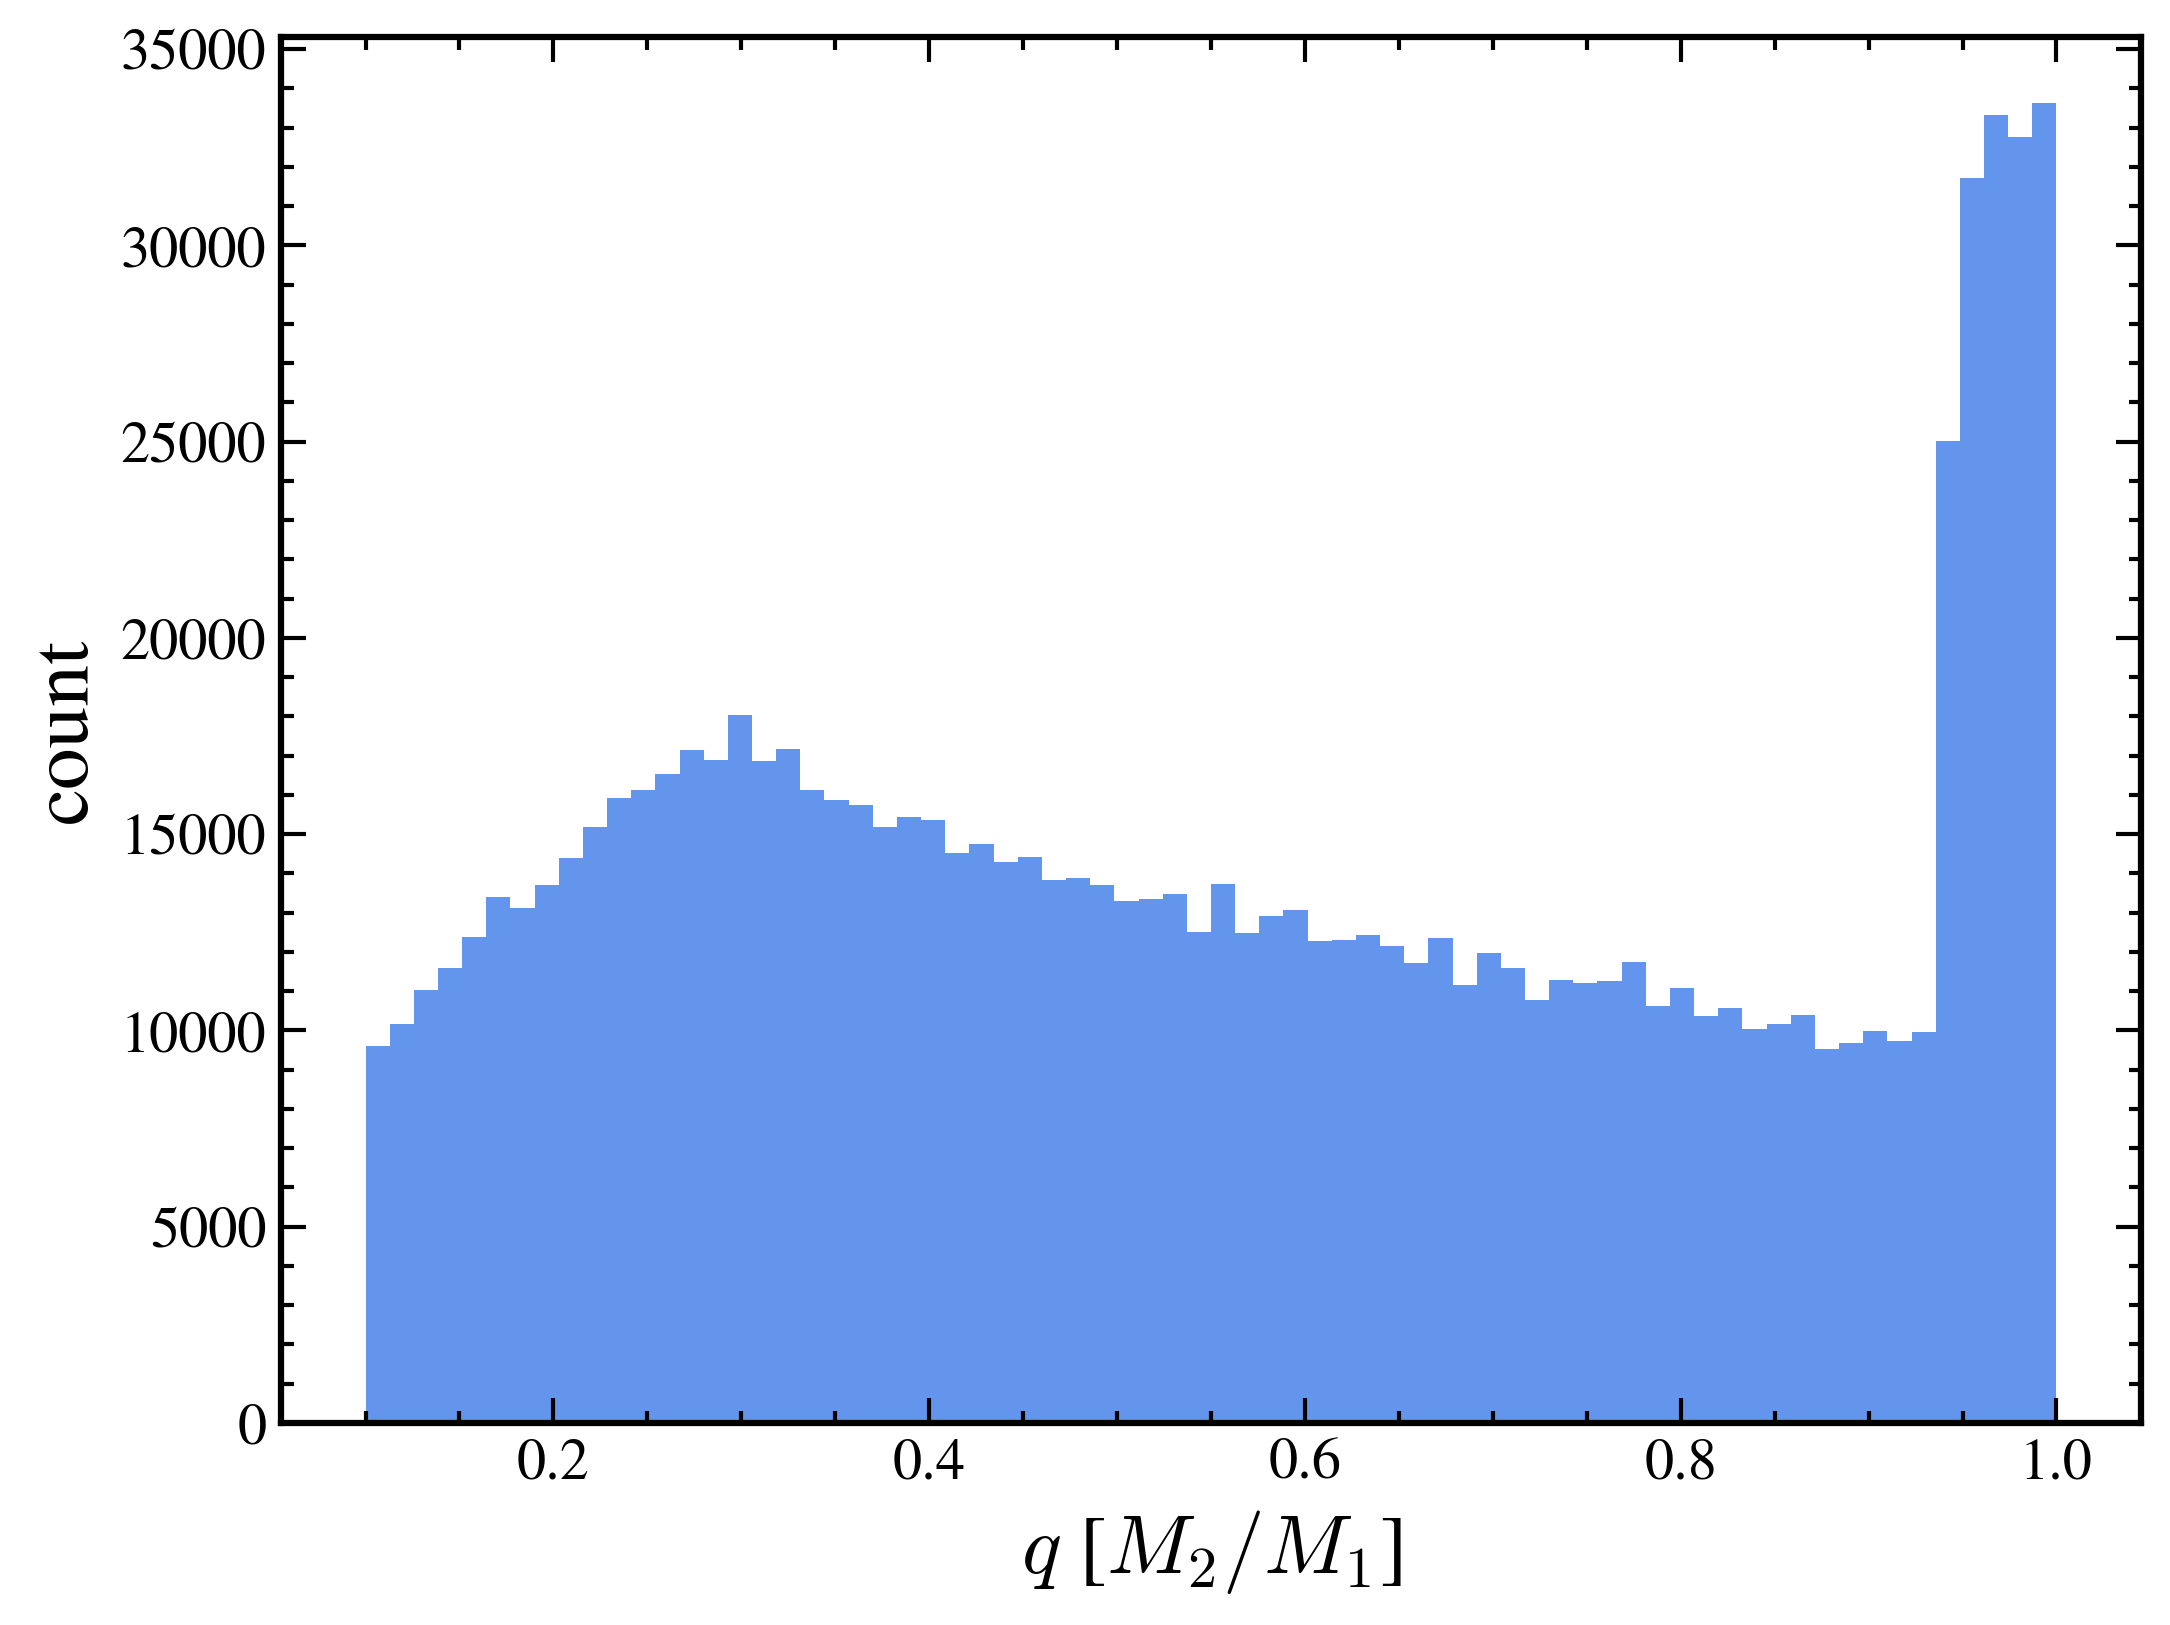

In [10]:
# plot the mass ratio distribution
qs = M2s/M1s
# plt.plot(qg, qw * 1e6, lw = 3)
fig, ax = plt.subplots(figsize=[8,6], dpi=300)
ax.hist(qs, bins = 70, color='cornflowerblue');

ax.set_ylabel('count', fontsize=20)
ax.set_xlabel(r'$q$ [$M_2/M_1$]', fontsize=20)

make_plot_nice(ax)
plt.savefig("plots/q_dist.pdf", dpi=300, bbox_inches="tight")
plt.savefig("plots/q_dist.png", dpi=300, bbox_inches="tight")

In [11]:
### generate inclinations and compute semiamplitudes
inclinations = draw_inclinations(N)
Ks = calc_amplitude(M1s * u.Msun, M2s * u.Msun, 10**logPs * u.day, eccs, inclinations).to(u.km/u.s).value

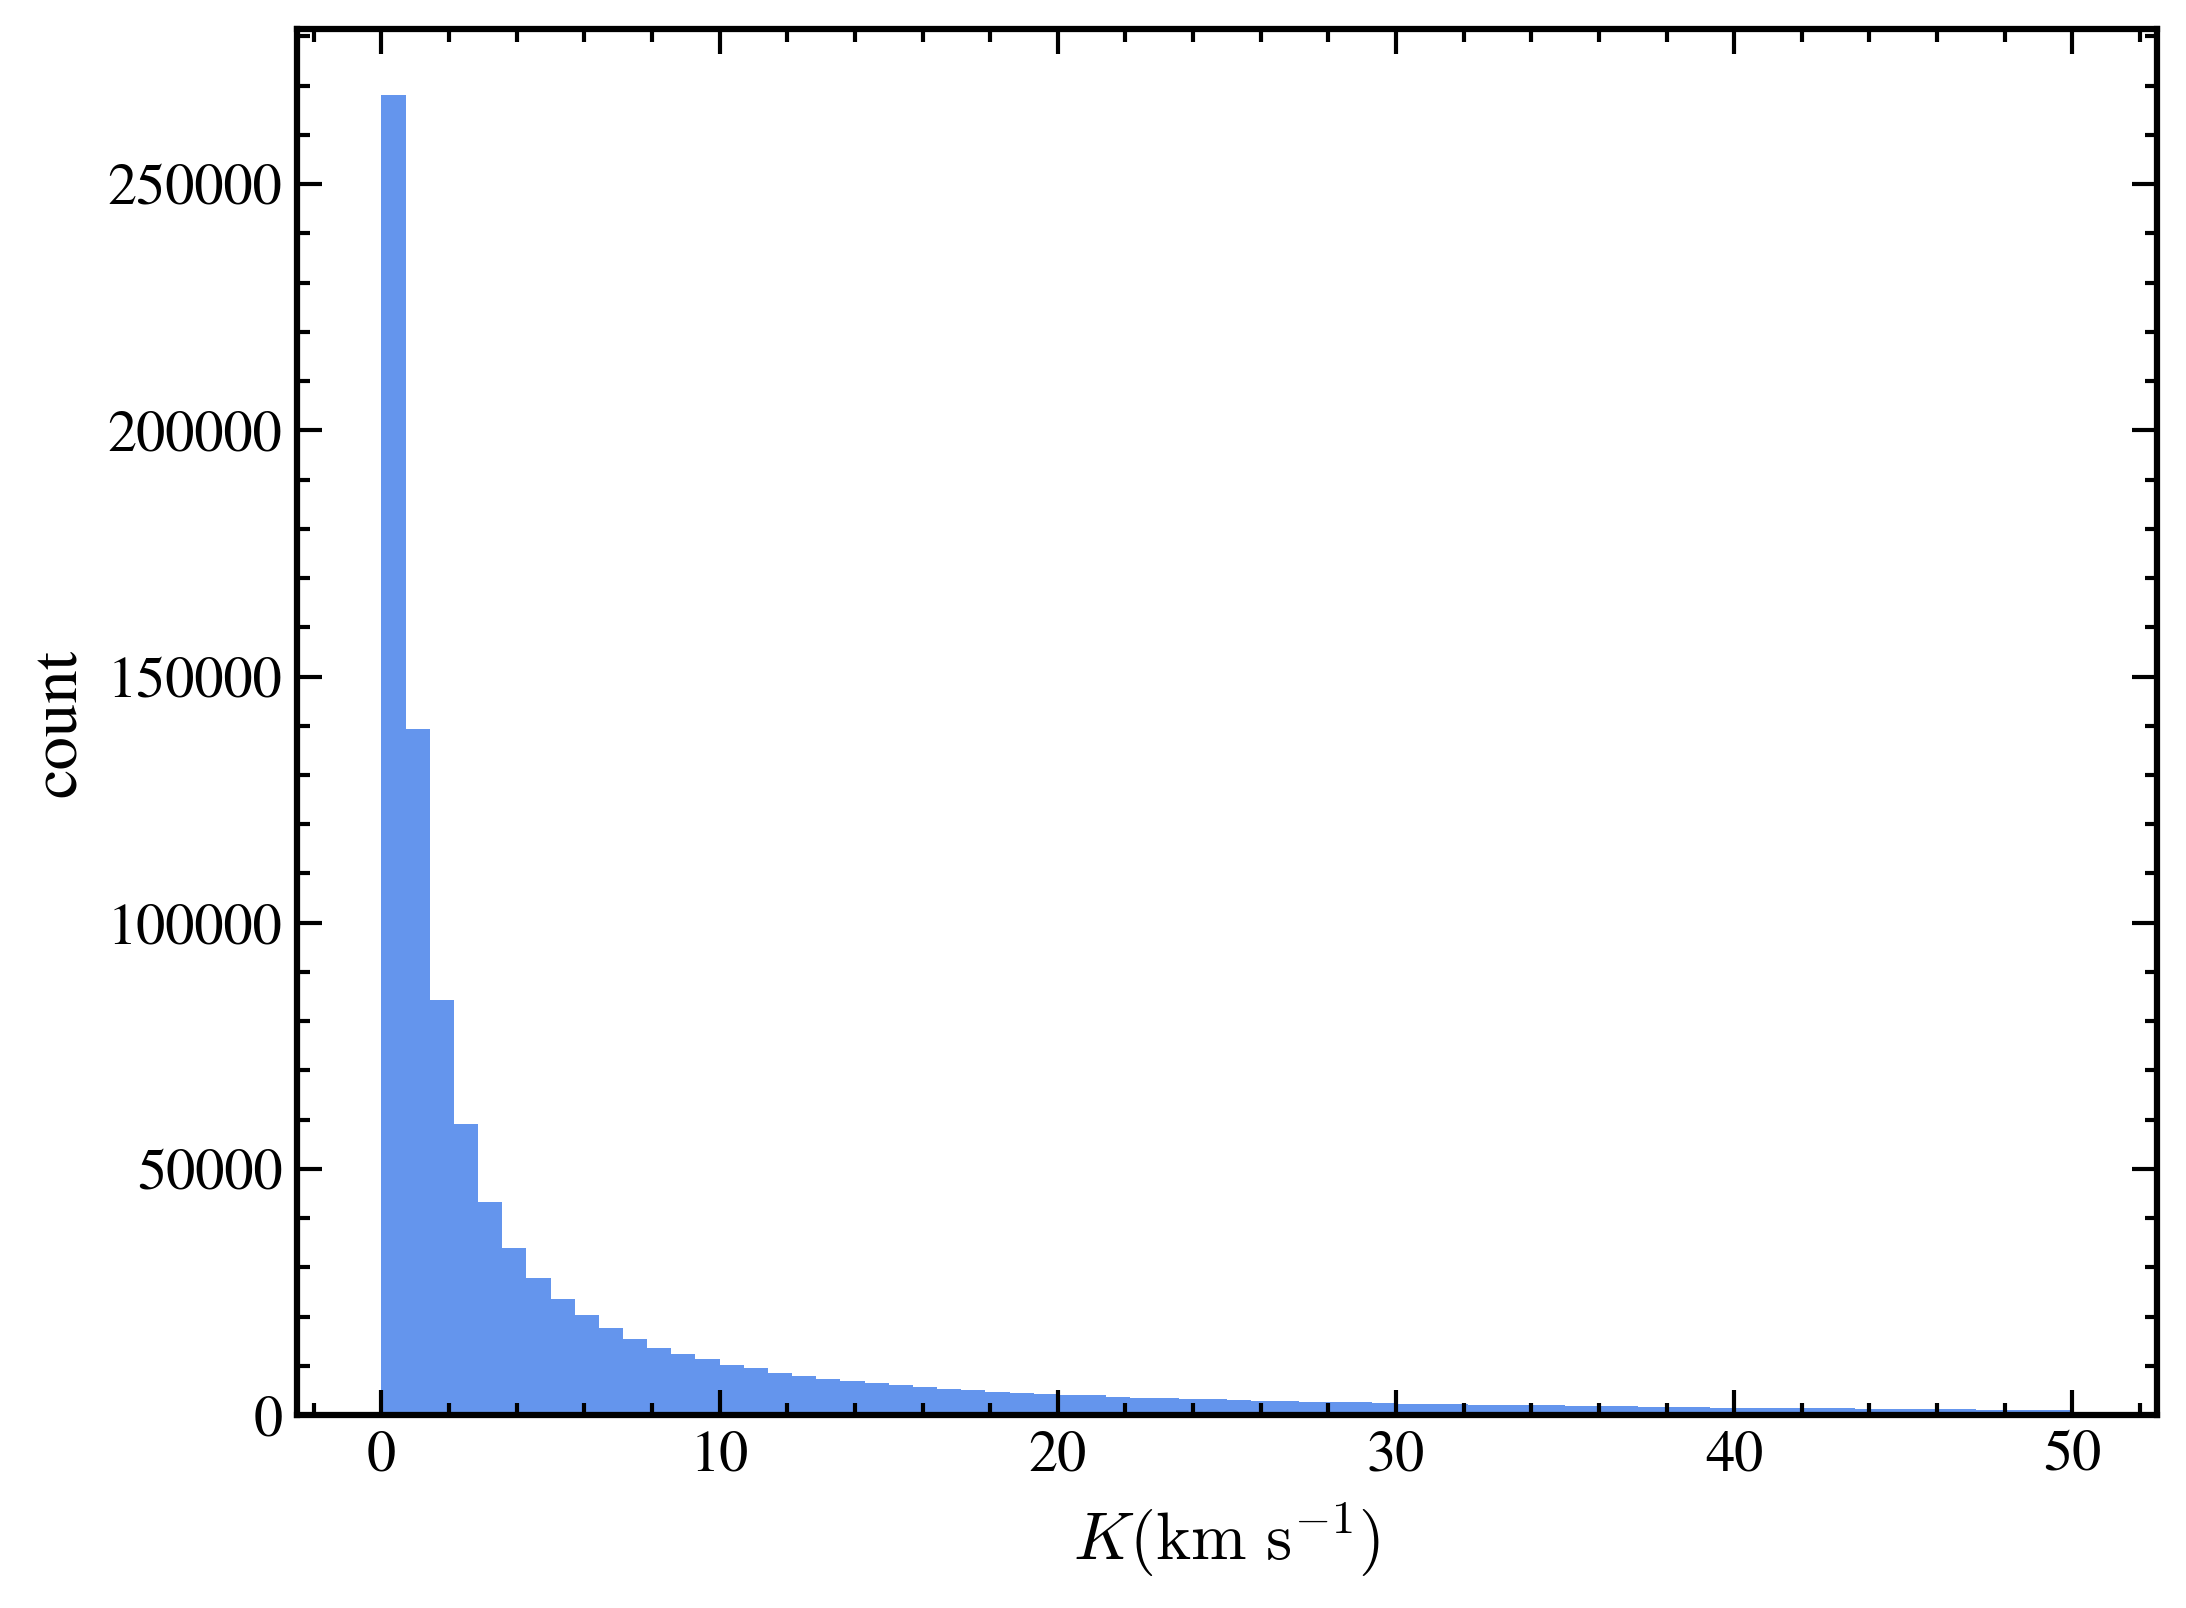

In [12]:
# plot semiamplitude distribution
fig, ax = plt.subplots(figsize=[8,6], dpi=300)
ax.hist(Ks, bins=70, color='cornflowerblue', range=(0, 50))
# ax.set_yscale('log')

ax.set_xlabel(r'$K (\rm{km\ s^{-1}})$')
ax.set_ylabel('count')

make_plot_nice(ax)
plt.savefig("plots/Ks_dist.pdf", bbox_inches='tight', dpi=300)
plt.savefig("plots/Ks_dist.png", bbox_inches="tight", dpi=300)
plt.show()

In [13]:
# generate arguments of periapsis, phi0 (periastron phase term), systemic velocity
ws = np.random.uniform(0, 2*np.pi, N)
phi0s = np.random.uniform(0, 1, N)

v0s = np.random.normal(loc=0.0, scale=30, size=N) # in km/s

In [14]:
### summarize labels:

labels = np.array([
    v0s, Ks, ws, phi0s, eccs, 10**(logPs)
]).T

print(labels.shape)

(1000000, 6)


## Mock observations: generate features

#### observation _times_

In [15]:
### observing
Nobs_g = np.array([3, 20])#np.arange(2, 6+1)

e_rv_g = np.array([0.1, 1.0, 3.0])
Ng = len(e_rv_g)

Nobsm = np.max(Nobs_g)

dt_min = 30 
dt_max = 125

rng = np.random.default_rng(seed = 42)

deltaTs = 10**rng.uniform(np.log10(dt_min), np.log10(dt_max), size = (N, Nobsm-1))  ### a *log* uniform distribution in deltaTs
#deltaTs = np.random.uniform(dt_min, dt_max, size = (Nstar, Nobsm - 1)) # N >= 2 visit s
deltaTs = np.column_stack((np.zeros(N), deltaTs)) # add t = 0 visit

obstimes_all = np.cumsum(deltaTs, axis = 1)
#obstimes_all = np.clip(obstimes_all, 0, 5 * 365.) # clip to 5-year

In [16]:
deltaTs.shape
total_baselines = obstimes_all[:, -1]
total_baselines_yr = total_baselines / 365
max(total_baselines_yr)

np.float64(5.016369735979832)

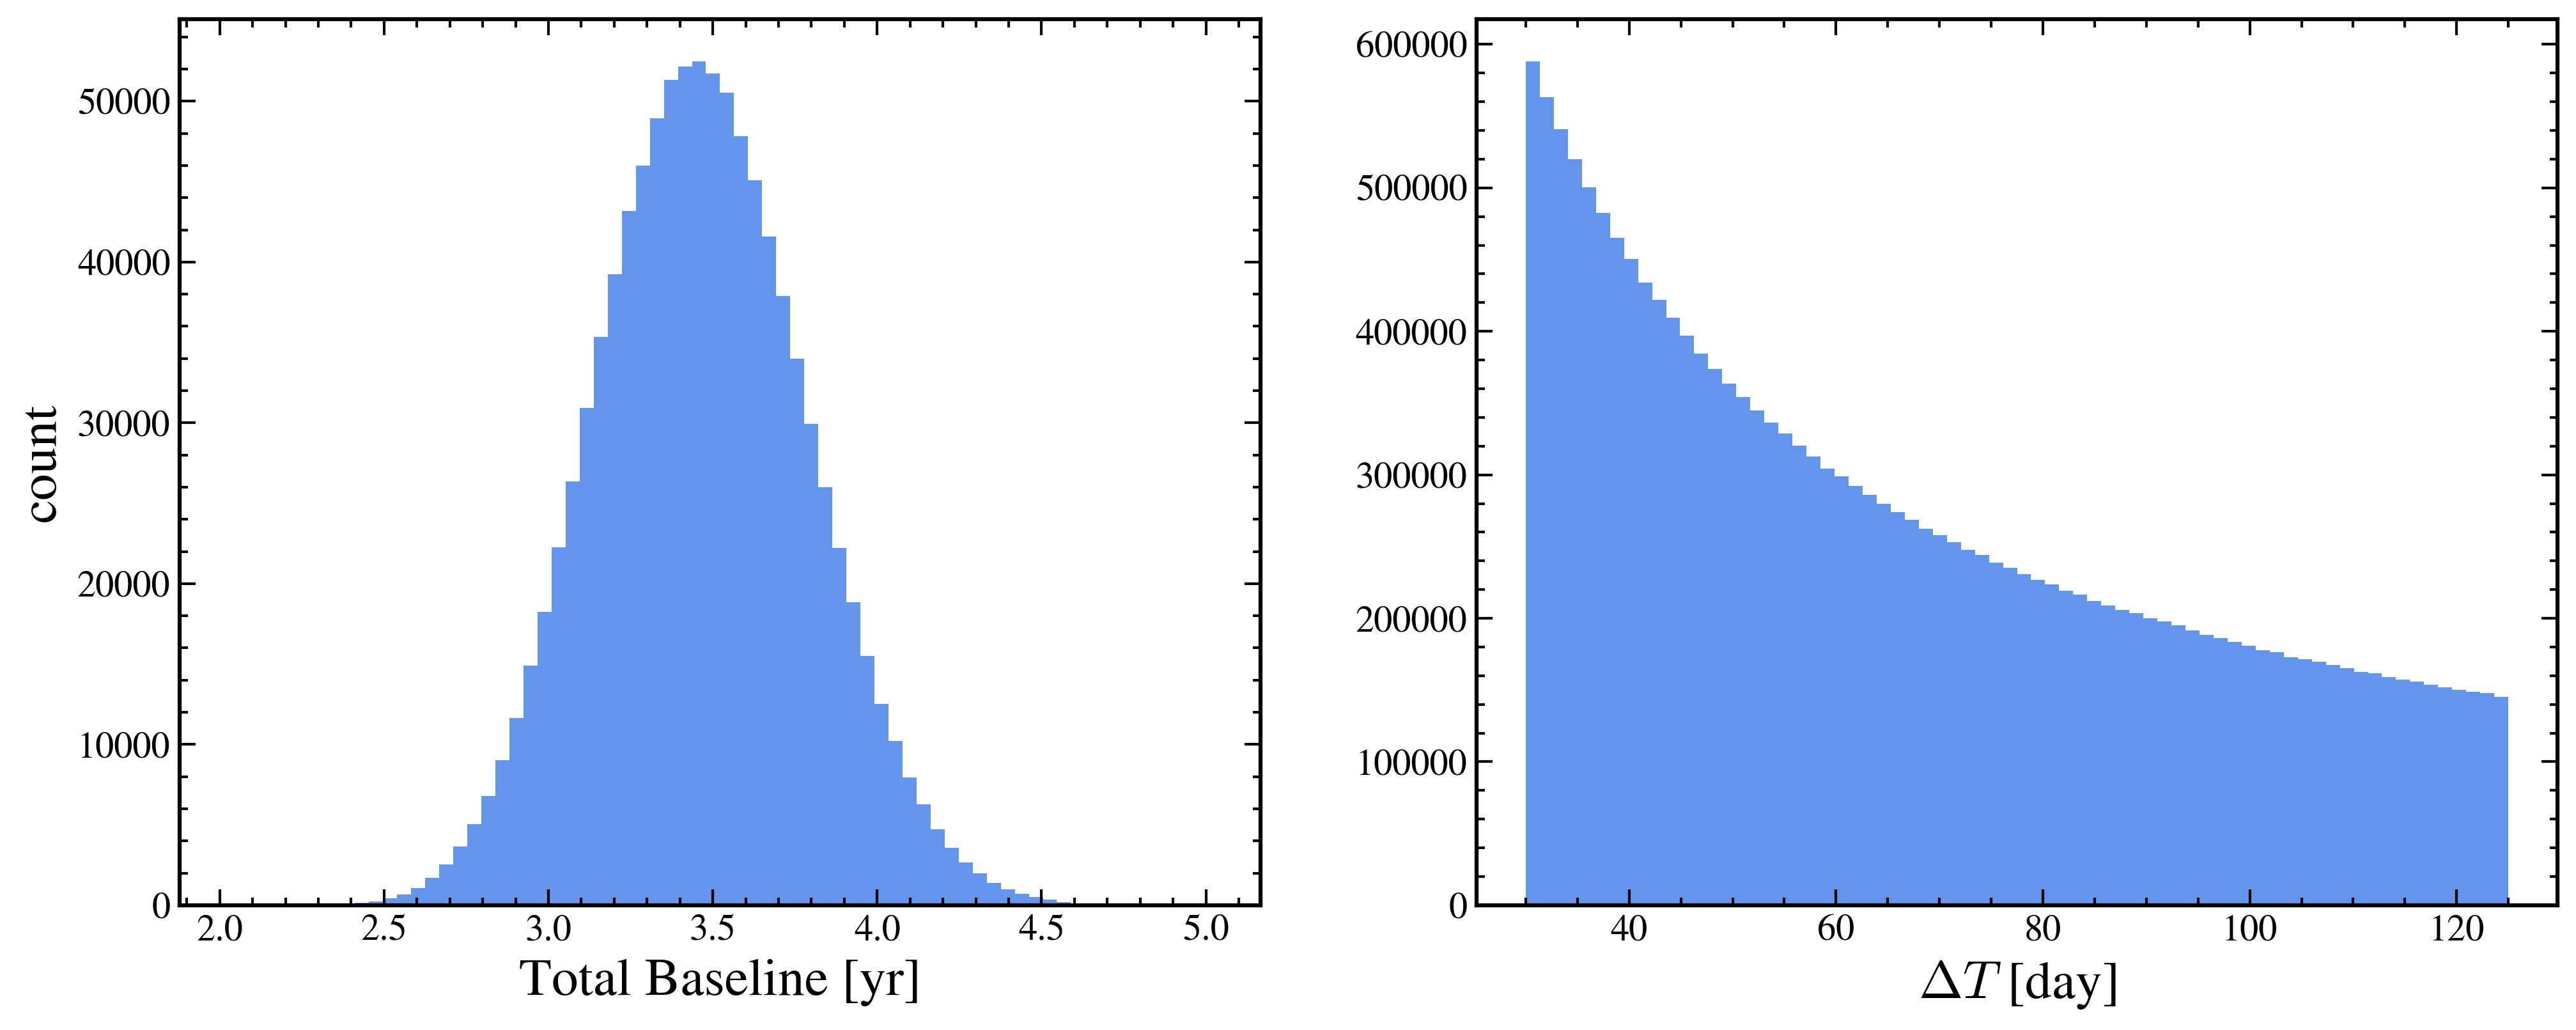

In [17]:
fig, [ax1,ax2] = plt.subplots(1,2,figsize=[16,6], dpi=300)

ax1.hist(total_baselines_yr, color='cornflowerblue', bins=70)
ax1.set_xlabel('Total Baseline [yr]', fontsize=20)
ax1.set_ylabel('count', fontsize=20)

ax2.hist(deltaTs[:, 1:].ravel(), color='cornflowerblue', bins=70);
ax2.set_xlabel('$\Delta T$ [day]', fontsize=20)

for ax in [ax1,ax2]:
    make_plot_nice(ax)

plt.savefig("plots/observing_strat.pdf", dpi=300, bbox_inches="tight")
plt.savefig("plots/observing_stat.png", bbox_inches='tight', dpi=300)

#### _radial velocities_

We'll numerically solve kepler's equation to generate RVs given times and orbit parameters:

In [18]:
## functions to do this.
def solve_kepler(M, e, tol=1e-10, max_iter=100):
    """
    mean anomaly M, eccentricity e
    """
    M = np.asarray(M)
    e = np.asarray(e)

    if M.shape != e.shape:
        e = np.full_like(M, e)

    E = M.copy()  # initial guess

    for _ in range(max_iter):
        f = E - e * np.sin(E) - M
        f_prime = 1 - e * np.cos(E)
        delta = f / f_prime

        delta = np.where(np.isfinite(delta), delta, 0.0)
        E_new = E - delta

        if np.all(np.abs(delta) < tol):
            break
        E = E_new

    E = np.where(np.isfinite(E), E, np.nan)
    return E

def true_anomaly(E, e):
    """
    true anom from eccentric anom
    """
    sqrt_1_plus_e = np.sqrt(np.clip(1 + e, 0, None))
    sqrt_1_minus_e = np.sqrt(np.clip(1 - e, 0, None))

    sin_E2 = np.sin(E / 2)
    cos_E2 = np.cos(E / 2)

    sin_E2 = np.nan_to_num(sin_E2)
    cos_E2 = np.nan_to_num(cos_E2)

    return 2 * np.arctan2(
        sqrt_1_plus_e * sin_E2,
        sqrt_1_minus_e * cos_E2
    )

def radial_velocity(t, v0, K, w, phi_0, e, P):
    """
    t : times at which to compute RV
    v0 : systemic velocity
    K : RV semiamplitude
    w : arg of periapsis
    e : eccentricity
    phi_0 : periastron?? phase term
    P : period (in same units as t)
    """
    M = 2 * np.pi * t / P - phi_0
    E = solve_kepler(M % (2 * np.pi), e)
    nu = true_anomaly(E, e)
    vr = v0 + K * (np.cos(nu + w) + e * np.cos(w))
    return vr

In [19]:
## generate the RVs, adding gaussian noise with 100 m/s errorbars

rvs_all = []

for i in tqdm(range(len(labels))):
    ts = obstimes_all[i]
    v0, K, w, phi_0, e, P = labels[i]

    rvs = radial_velocity(ts, v0, K, w, phi_0, e, P)
    rvs_noised = rvs + np.random.normal(0, 0.1, size=ts.shape)
    rvs_all.append(rvs_noised)

rvs_all = np.array(rvs_all)

100%|██████████| 1000000/1000000 [00:50<00:00, 19639.45it/s]


#### visualize the results

In [20]:
## function for phase folding
def compute_phase(t, P, T0=0.0):
    return ((t - T0) / P) % 1

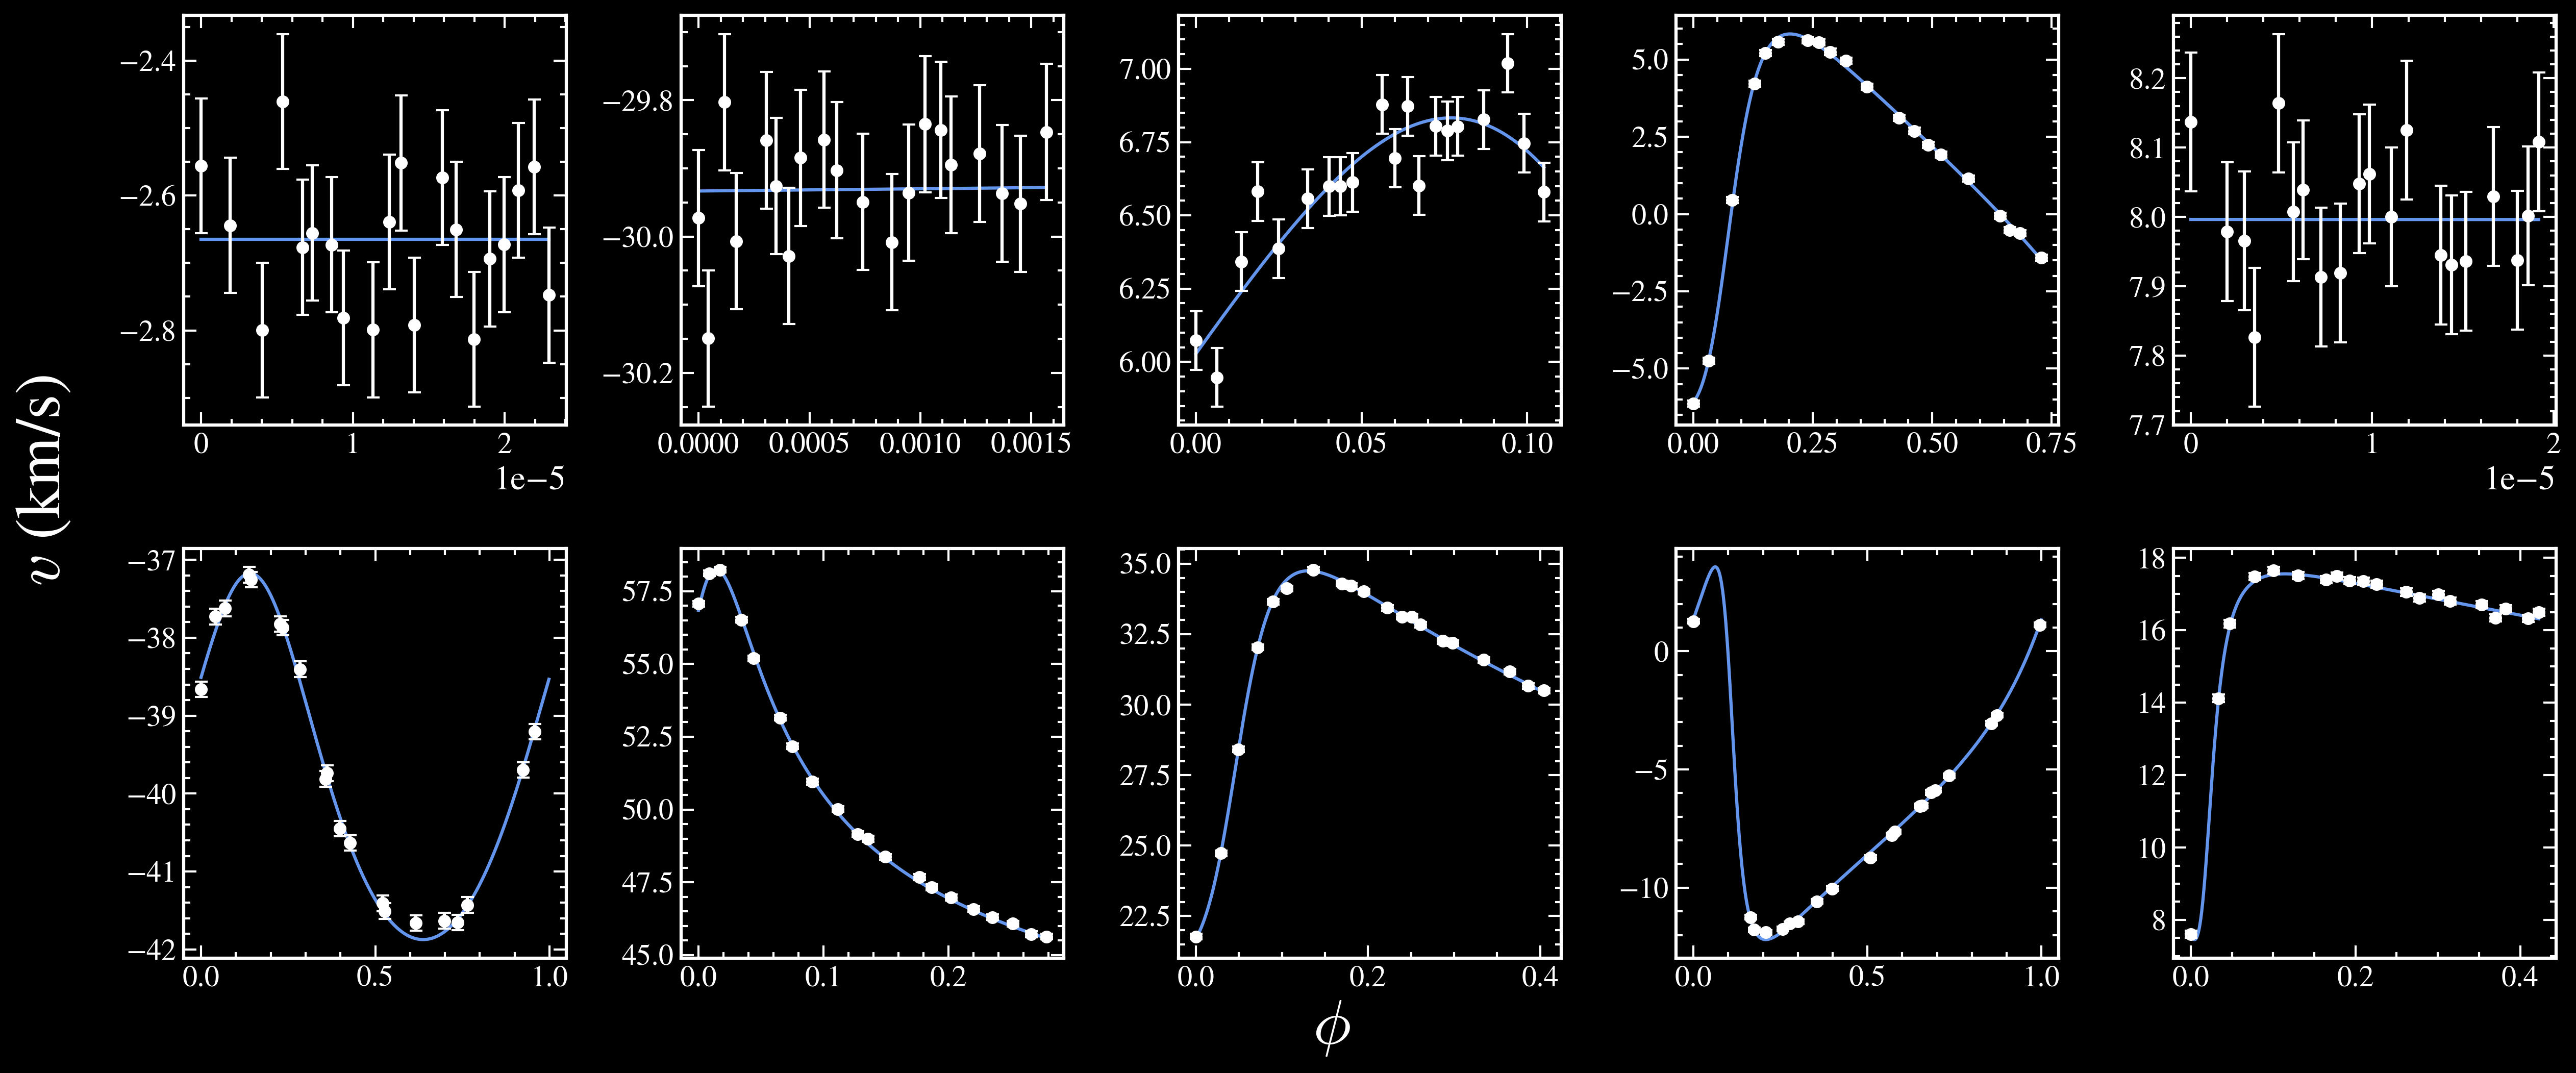

In [22]:
indices_to_check = np.random.randint(0, N, 10)
with plt.style.context("dark_background"):
    fig, [[ax1,ax2,ax3,ax4,ax5],[ax6,ax7,ax8,ax9,ax10]] = plt.subplots(2,5,figsize=[20,8], dpi=300)
    plt.subplots_adjust(wspace=.3, hspace=.3)
    axs = [ax1,ax2,ax3,ax4,ax5, ax6,ax7,ax8,ax9,ax10]

    for i in range(len(indices_to_check)):
        j = indices_to_check[i]
        ts = obstimes_all[j]
        rvs = rvs_all[j]
        v0, K, w, phi_0, e, P = labels[j]


        t_model = np.linspace(0, max(ts), 1000)
        v_model = radial_velocity(t_model, v0, K, w, phi_0, e, P)
        phase_model = compute_phase(t_model, P=P, T0=ts[0])
        sort_idx = np.argsort(phase_model)
        phase_model = phase_model[sort_idx]
        rv_model = v_model[sort_idx]



        ax = axs[i]
        ax.plot(phase_model, rv_model, c='cornflowerblue', zorder=0)
        ax.errorbar(compute_phase(ts, P, 0.), rvs, yerr=0.1, marker='o', linestyle='', markersize=5, capsize=3, c='white')
        make_plot_nice(ax)

    fig.text(0.5,0.04, r"$\phi$", ha='center', fontsize=30)
    fig.text(0.07, 0.5, r"$v$ (km/s)", rotation='vertical', va='center', fontsize=30)

plt.savefig("plots/example_RVcurves_generated_darkmode.pdf", dpi=300, bbox_inches="tight", transparent=True)
# plt.savefig("plots/example_RVcurves_generated.png", dpi=300, bbox_inches="tight")

# Save all data

In [24]:
features = np.hstack([rvs_all, obstimes_all])
features.shape, labels.shape

((1000000, 40), (1000000, 6))

In [ ]:
np.savez_compressed("data/trts_data_with_errors_compressed.npz", # compress array for github uploading purposes
                    features=features,
                    labels=labels)

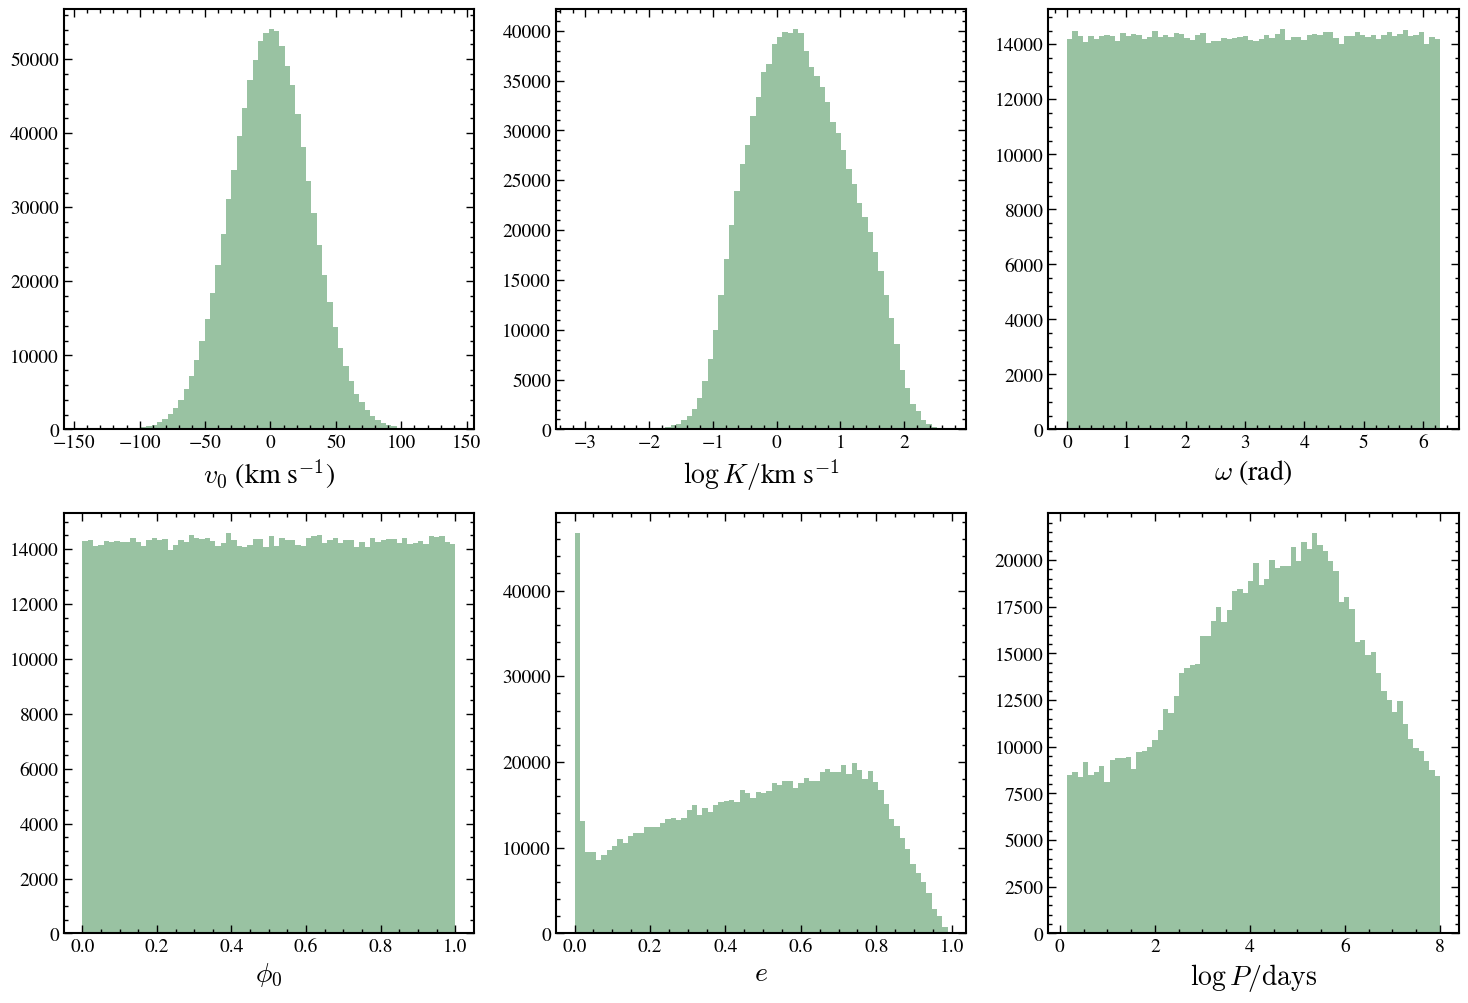

In [26]:
### make sure that worked:
dat = np.load('data/trts_data_with_errors_compressed.npz')
features = dat['features'] ### 20 RVs, 20 timestamps
labels = dat['labels'] ### v0, K, w, phi_0, e, P
v0, K, w, phi0, e, P = labels.T
fig, [[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2,3, figsize=[18,12])
ax_list = [ax1,ax2,ax3,ax4,ax5,ax6]
param_names = [r"$v_0$ (km s$^{-1}$)", r"$\log{K/}$km s$^{-1}$", r'$\omega$ (rad)', r'$\phi_0$', r'$e$', r'$\log{P/\rm{days}}$']
params_list = [v0, K, w, phi0, e, P]
for i in range(len(params_list)):
    ax = ax_list[i]
    if i==1 or i==5:
        ax.hist(np.log10(params_list[i]), color="#99C2A2", bins=70)
    else:
        ax.hist(params_list[i], color='#99C2A2', bins=70)
    ax.set_xlabel(param_names[i], fontsize=20)
    make_plot_nice(ax)
    # ax.set_yscale('log')